# Bias & Fairness: Modeling Recidivism

#### Loading Libraries & Data

In [6]:
# Numerical Manipulation
import numpy as np
# Data Management
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Bias Measurement
from sklearn.metrics import classification_report

# import dalex as dx

In [7]:
compas_df = pd.read_csv('/Users/isisromero/desktop/feature_engineering/data/compas-scores-two-years.csv')

In [8]:
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


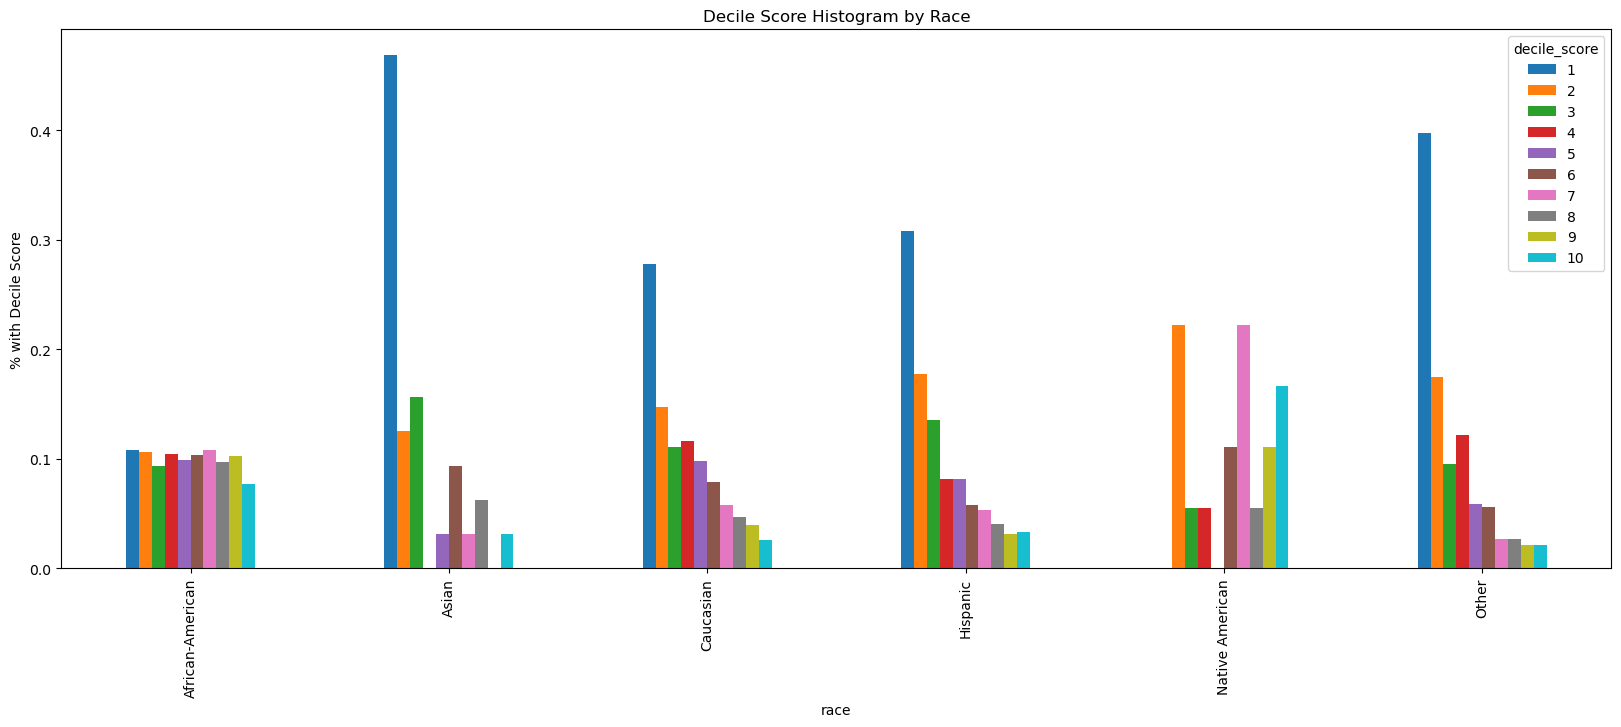

In [9]:
compas_df.groupby('race')['decile_score'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar', figsize=(20, 7),
    title='Decile Score Histogram by Race', ylabel='% with Decile Score')

plt.show()

In [10]:
# Courts generally use  a decile score of 5 to label someone as being medium risk.
compas_df['is_med_or_high_risk'] = (compas_df['decile_score']>=5).astype(bool)

In [11]:
# Not great if the court's system of 5 or higher on the decile score is only accurate 65% of the time
(compas_df['is_med_or_high_risk']==compas_df['two_year_recid']).mean()

0.6537288605489326

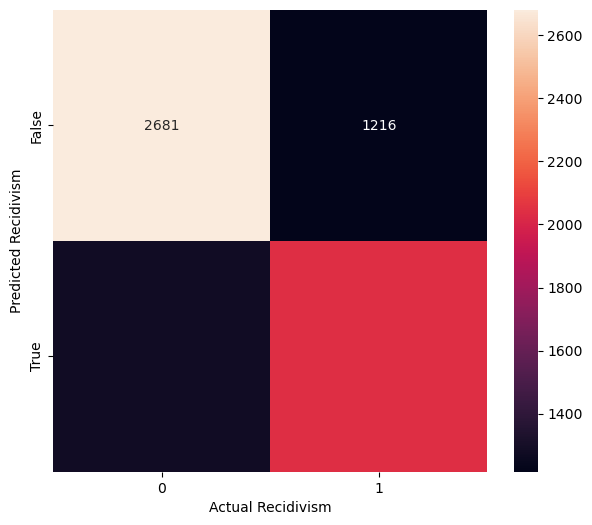

In [12]:
# Recidivism HeatMap
cm = pd.crosstab(
    compas_df['is_med_or_high_risk'], compas_df['two_year_recid'], 
    rownames=['Predicted Recidivism'], colnames=['Actual Recidivism']
)
p = plt.figure(figsize=(7,6))
p = sns.heatmap(cm, annot=True, fmt='d')

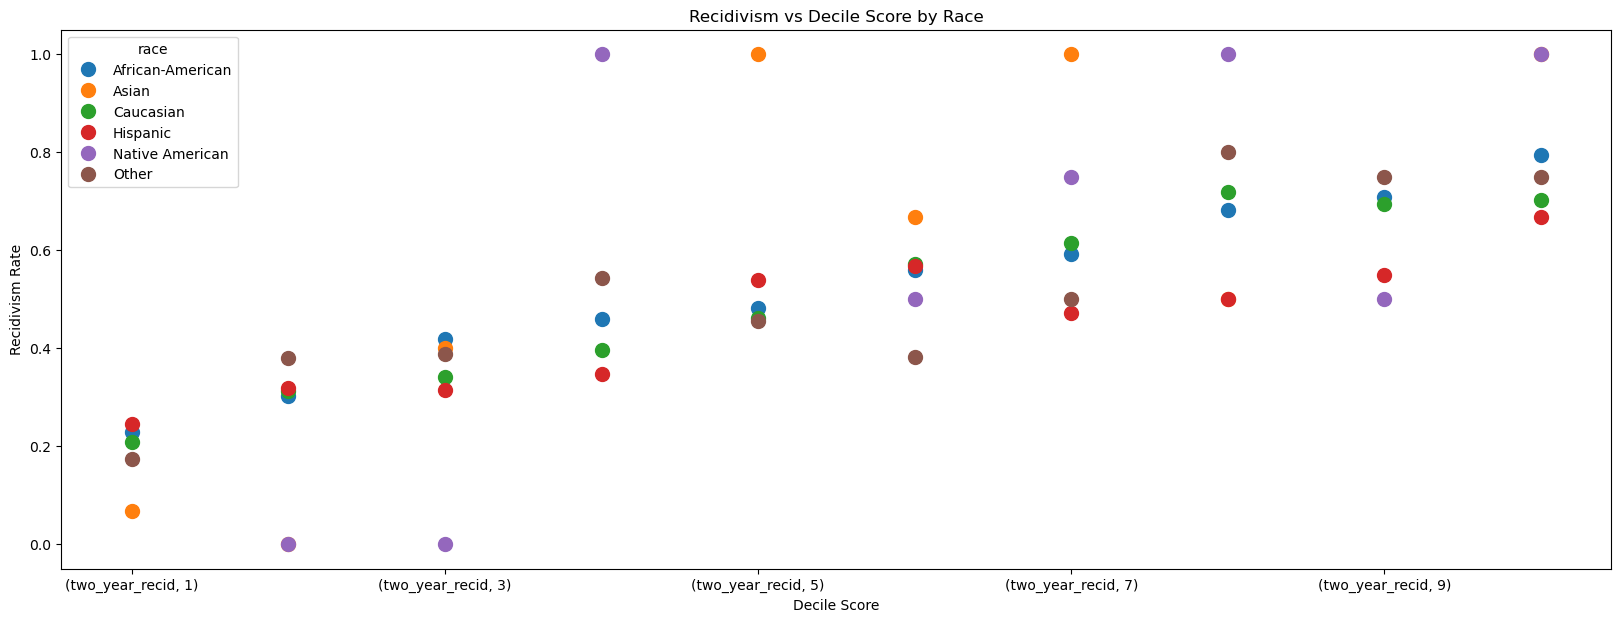

In [13]:
# scatter plot 
compas_df.groupby(
    ['race', 'decile_score']
)[['two_year_recid']].mean().unstack().T.plot(
    xlabel='Decile Score', ylabel='Recidivism Rate', title='Recidivism vs Decile Score by Race',
    style='.', figsize=(20, 7),
    ms=20
)

plt.show()

### Exploratory Data Analysis

In [14]:
compas_df.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Asian,32.0,0.281250,0.456803,0.0,0.0,0.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Native American,18.0,0.555556,0.511310,0.0,0.0,1.0,1.0,1.0
Other,377.0,0.352785,0.478472,0.0,0.0,0.0,1.0,1.0


In [15]:
# Relabel rows with Asian/Native American races as Other
compas_df.loc[compas_df['race'].isin(['Native American', 'Asian']), 'race'] = 'Other'

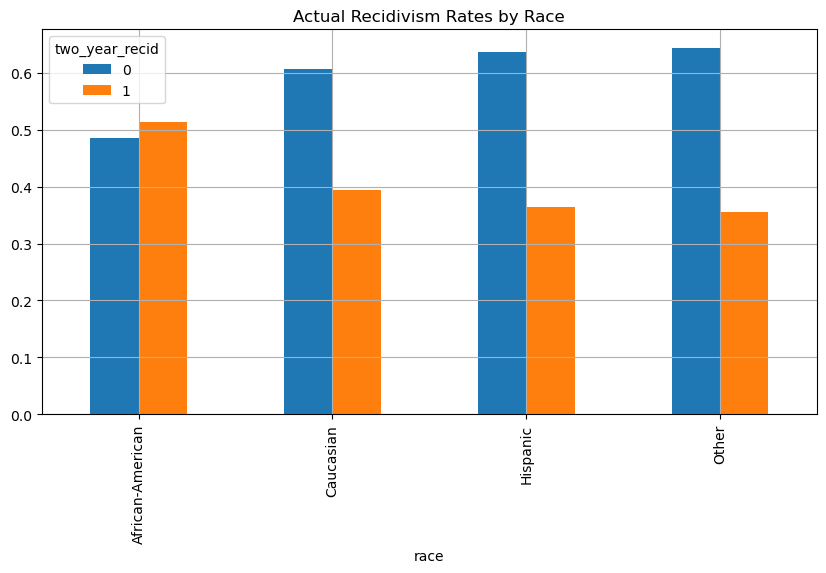

In [16]:
# Plot recidivism rates from the four races we are considering
compas_df.groupby('race')['two_year_recid'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar', figsize=(10, 5), title='Actual Recidivism Rates by Race')

plt.grid(True)
plt.show()

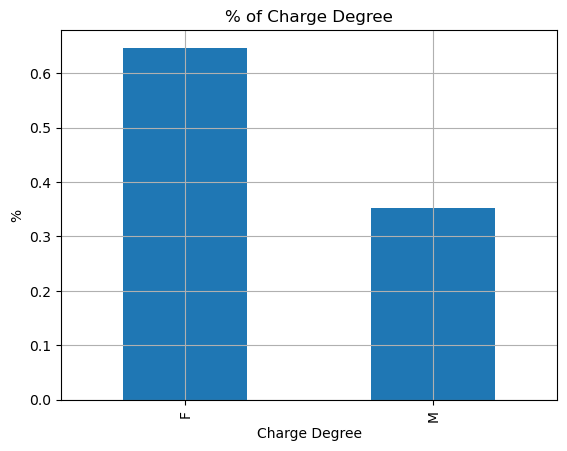

In [17]:
compas_df['c_charge_degree'].value_counts(normalize=True).plot(
    kind='bar', title='% of Charge Degree', ylabel= '%', xlabel='Charge Degree')

plt.grid(True)
plt.show()

#### Plotting on Quantitative Variables

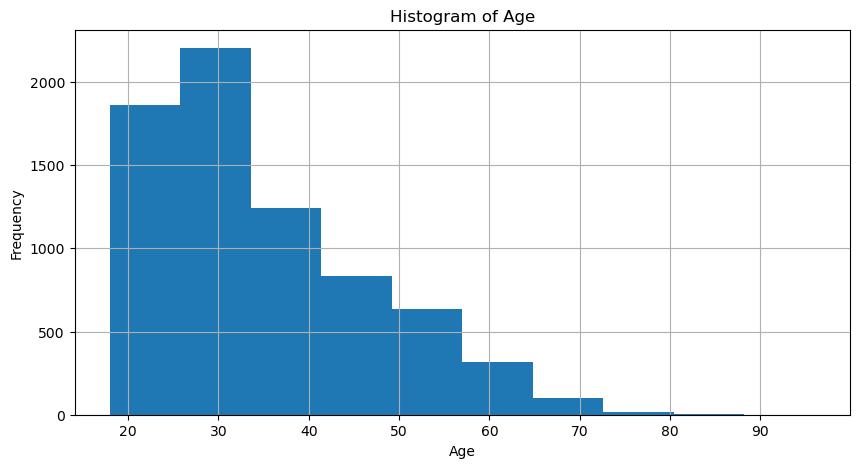

In [18]:
# Right skew on Age
compas_df['age'].plot(
    title='Histogram of Age', kind='hist', xlabel='Age', figsize=(10, 5)
)

plt.grid(True)
plt.show()

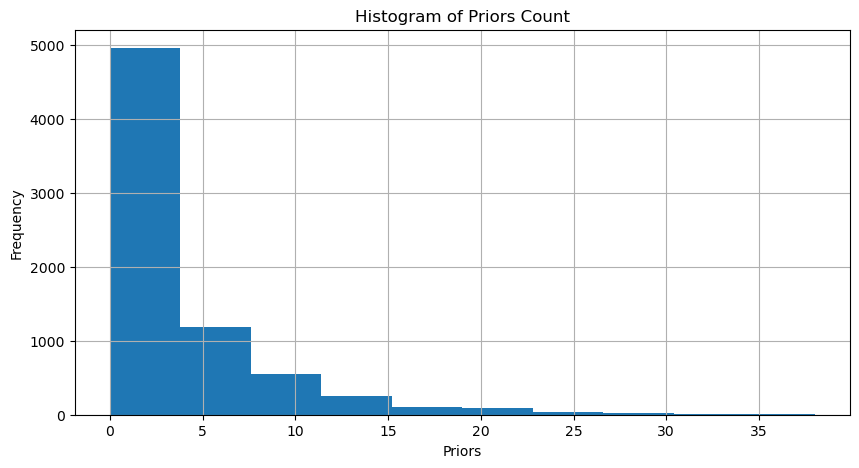

In [19]:
#Right skew on Priors
compas_df['priors_count'].plot(
    title='Histogram of Priors Count', kind='hist', xlabel='Priors', figsize=(10, 5)
)

plt.grid(True)
plt.show()

### Building a Baseline Model

#### Feature Construction

In [20]:
compas_df[["juv_fel_count", "juv_misd_count", "juv_other_count"]].describe()

,juv_fel_count,juv_misd_count,juv_other_count
count,7214.000000,7214.000000,7214.000000
mean,0.067230,0.090934,0.109371
std,0.473972,0.485239,0.501586
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,20.000000,13.000000,17.000000


In [21]:
# New Total Juvenile Offense Count
compas_df['juv_count'] = compas_df[["juv_fel_count", "juv_misd_count", "juv_other_count"]].sum(axis=1)

In [22]:
# Removing the Original Juvenile Feature
compas_df = compas_df.drop(["juv_fel_count", "juv_misd_count", "juv_other_count"], axis=1)

#### Building our Baseline Pipeline

In [23]:
# Split up our data 
X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(compas_df.drop('two_year_recid', axis=1),
                                                    compas_df['two_year_recid'],
                                                    compas_df['race'],
                                                    stratify=compas_df['two_year_recid'],
                                                    test_size=0.3,
                                                    random_state=0)

# our static classifier
classifier = RandomForestClassifier(max_depth=10, n_estimators=20, random_state=0)

In [24]:
# Qualitative Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_features = ['race', 'sex', 'c_charge_degree']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary'))
    
])

In [25]:
# Quantitative Pipeline
numerical_features = ['age', 'priors_count']
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

In [26]:
# Merging on One Feature PreProcessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

clf_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [27]:
clf_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['race', 'sex',
                                                   'c_charge_degree']),
                                                 ('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'priors_count'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=20,
                                        random_state=0))])

In [28]:
unaware_y_preds = clf_tree.predict(X_test)

In [29]:
!pip install dalex

#### Measuring Bias on Baseline Model

In [30]:
# import dalex as dx

# exp_tree = dx.Explainer(
#     clf_tree, X_test, y_test,
#     label='Random Forest Bias Unaware', verbose=True)

In [31]:
# exp_tree.model_performance()

In [32]:
# print(classification_report(y_true=y_test, y_pred=unaware_y_preds))

In [33]:
# exp_tree.model_parts().plot()

In [34]:
# mf_tree = exp_tree.model_fairness(protected=race_test, privileged = "Caucasian")

# # TPR(r) = TP / AP                           ( aka sensitivity )
# # TNR(r) = TN / AN                           ( aka specificity )
# # PPV(r) = TP / (PP)                         ( aka precision )
# # NPV(r) = TN / (PN)                    
# # FNR(r) = FN / AP  OR 1 - TPR                   
# # FPR(r) = FP / AN  OR 1 - TNR                   
# # FDR(r) = FP / (PP) OR 1 - PPV
# # FOR(r) = FN / (PN) OR 1 - NPV         
# # ACC(r) = TP + TN  / (TP + TN + FP + FN)    ( Overall accuracy by Race)
# # STP(r) = TP + FP / (TP + FP + FP + FN)     ( aka P[recidivism predicted | Race=r] )

# mf_tree.metric_scores